In [1]:
import math
import pandas as pd
import numpy as np
from keras.layers import Dense, Activation, Input, Flatten
from keras.models import Sequential
from keras.utils import to_categorical
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Variables

In [2]:
file_name = 'data/merchants_data.csv'

In [3]:
out_file_name = 'data/merchants_data_extracted.csv'

### Load and prepare data

In [4]:
data = pd.read_csv(file_name, sep="?") # Data previously separated with ?

In [5]:
data.shape

(65983, 3)

In [6]:
data.columns

Index(['merchant_string', 'raw_trans_string', 'clean_trans_string'], dtype='object')

Filter rows to keep the ones only containing the merchant string (substring) in the raw_trans_string

In [7]:
df_without_merchant_in_string = data[data.apply( lambda x: x[0].lower() not in x[1].lower(), axis=1)]

In [8]:
data = data[data.apply( lambda x: x[0].lower() in x[1].lower(), axis=1)]

In [9]:
data = data.drop_duplicates("raw_trans_string")

In [10]:
data = data.reset_index(drop=True)

In [11]:
data = data.sample(data.shape[0]) # Randomize data

In [12]:
data['raw_trans_string'] = data['raw_trans_string'].str.replace(r'\s+', ' ')

In [13]:
# Limit text string to pad size

In [14]:
pad_size = 200 # Padding up to 200 PAD Symbols to the text

In [15]:
data['raw_trans_string'] = data[['raw_trans_string']].apply(lambda x: x[0][0:pad_size], axis=1)

In [16]:
data.shape

(13331, 3)

In [17]:
# Add begin marker cell to the dataframe

In [18]:
data["begin_marker"] = data[['merchant_string','raw_trans_string']].apply(lambda x: x[1].lower().find(x[0].lower()), axis=1)

In [19]:
# Add end marker cell to the dataframe

In [20]:
data['end_marker'] = data[['merchant_string', 'begin_marker']].apply(lambda x: x[1] + len(x[0]), axis=1)

In [21]:
data.head()

merchant_string                                   raw_trans_string  \
7771           ExxonMobil                     EXXONMOBIL 47887179 ASHBURN VA   
10550            TiVo Inc  TIVO INC. TIVO INC. 1-877-367-8 3088655624 www...   
12349  Cheesecake Factory            CHEESECAKE FACTORY #136 HUNTINGTON STNY   
12206            Key Food                        KEY FOODS #0890 BROOKLYN NY   
5617              Netflix     NETFLIX.COM NETFLIX.COM 6369040451 DVD RENTALS   

                        clean_trans_string  begin_marker  end_marker  
7771                            EXXONMOBIL             0          10  
10550     TIVO INC. TIVO INC. WWW.TIVO.COM             0           8  
12349   CHEESECAKE FACTORY HUNTINGTON STNY             0          18  
12206                            KEY FOODS             0           8  
5617   NETFLIX.COM NETFLIX.COM DVD RENTALS             0           7

In [22]:
for _ in range(100):
    i = np.random.randint(data.shape[0])
    extracted_merchant_name = data["raw_trans_string"].loc[i][data["begin_marker"][i]:data["end_marker"][i]]
    orig_merchant_name = data['merchant_string'].loc[i]
    assert(extracted_merchant_name.lower() == orig_merchant_name.lower())

In [23]:
# Create vocabulary with UNKNOWNS AND PAD Symbols

In [24]:
UNKNOWN = 'UNKNOWN'
PAD = 'PAD'
vocab = [UNKNOWN, PAD]

In [25]:
chars = set([ c for text in data['raw_trans_string'].values for c in text ])

In [26]:
for c in chars:
    vocab.append(c)

In [27]:
char2index = dict((c, i) for i, c in enumerate(vocab)) # Unnecessary variables but easier
index2char = dict((i, c) for i, c in enumerate(vocab))

#### Create training/testing

In [28]:
data['encoded_text'] = [ [char2index[char] for char in text] for text in data['raw_trans_string'].values ]

In [29]:
df_without_merchant_in_string['encoded_text'] = df_without_merchant_in_string[['raw_trans_string']].apply(lambda x: \
    [ char2index[char] if char in char2index.keys() else char2index[UNKNOWN] for char in x[0] ], axis=1 \
)

In [30]:
def pad_vector(vector, pad_size, padding):
    vector[len(vector):pad_size] = np.repeat(padding, pad_size - len(vector))
    return vector

In [31]:
data['encoded_text_padded'] = data[['encoded_text']].apply( lambda x: pad_vector(x[0], pad_size, char2index[PAD] ), axis=1)

In [32]:
df_without_merchant_in_string['encoded_text_padded'] = df_without_merchant_in_string[['encoded_text']].apply( lambda x: pad_vector(x[0], pad_size, char2index[PAD] ), axis=1)

In [33]:
assert(len(data['encoded_text_padded'].loc[0]) == pad_size) # Encoded text has same number of characters as original string plus the marquers

In [34]:
#### One hot encoding text

In [35]:
X = np.zeros((data['encoded_text_padded'].shape[0], pad_size, len(vocab)))

In [36]:
for i, vector in enumerate(data['encoded_text_padded'].values):
    for j, char in enumerate(vector):
        X[i, j, char] = 1

In [37]:
def one_hot_encode_df(data, vector_column, pad_size, vocab_len):
    X = np.zeros((data[vector_column].shape[0], pad_size, vocab_len))
    for i, vector in enumerate(data[vector_column].values):
        for j, char in enumerate(vector):
            X[i, j, char] = 1
    return X

In [38]:
### Create Targets

In [39]:
Y_begin = to_categorical(data['begin_marker'].values, int(pad_size / 2))
Y_end = to_categorical(data['end_marker'].values, int(pad_size / 2))

In [40]:
#### Create class weights

In [41]:
def create_class_weight(labels_dict, mu=0.15):
    total = sum(labels_dict.values())
    class_weight = dict()

    for key, value in labels_dict.items():
        score = math.log(mu * total / value)
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [42]:
start_class_freqs = data.groupby('begin_marker')['merchant_string'].agg(['count'])['count']

In [43]:
begin_class_weights = create_class_weight(start_class_freqs.to_dict())

In [44]:
end_class_freqs = data.groupby('end_marker')['merchant_string'].agg(['count'])['count']

In [45]:
end_class_weights = create_class_weight(end_class_freqs.to_dict())

In [46]:
### Build NN

In [47]:
BATCH = 32
EPOCHS = 4

In [48]:
def build_model(input_shape):
    model = Sequential()
    model.add(Dense(input_shape[0], input_shape=input_shape, activation="relu"))
    model.add(Flatten())
    model.add(Dense(int(input_shape[0] / 2)))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [49]:
def build_model_2(input_shape):
    model = Sequential()
    model.add(Dense(input_shape[0] * input_shape[1], input_shape=input_shape, activation="relu"))
    model.add(Flatten())
    model.add(Dense(int(input_shape[0])))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [50]:
def build_dyn_model(input_shape, layers):
    model = Sequential()
    for i,layer in enumerate(layers):
        if i == 0:
            model.add(Dense(layer['hidden_nb'], input_shape=input_shape, activation=layer['activation']))
        elif i == len(layers) - 1:
            model.add(Flatten())
            model.add(Dense(layer['hidden_nb']))
        else:
            #model.add(Flatten())
            model.add(Dense(layer['hidden_nb'], activation=layer['activation']))
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
    return model

In [51]:
### Train and test simple

In [81]:
model = build_model((pad_size, len(vocab)))

In [53]:
#Y = np.array([hot_encode_index_pos(index, pad_size) for index in data[['begin_marker']].values ])

In [97]:
model_output = model.fit(X, Y_begin, batch_size=BATCH, epochs=EPOCHS, class_weight=begin_class_weights)

Epoch 1/4
13331/13331 [==============================] - 5s 395us/step - loss: 0.2009 - acc: 0.9756
Epoch 2/4
13331/13331 [==============================] - 5s 395us/step - loss: 0.1779 - acc: 0.9785
Epoch 3/4
13331/13331 [==============================] - 5s 394us/step - loss: 0.1592 - acc: 0.9793
Epoch 4/4
13331/13331 [==============================] - 5s 393us/step - loss: 0.1445 - acc: 0.9812


In [100]:
model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13_input (InputLayer)  (None, 200, 81)           0         
_________________________________________________________________
dense_13 (Dense)             (None, 200, 200)          16400     
_________________________________________________________________
flatten_4 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               4000100   
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0         
Total params: 4,016,500
Trainable params: 4,016,500
Non-trainable params: 0
_________________________________________________________________


In [52]:
layers = [ { 'hidden_nb': 1024, 'activation': 'relu'} , { 'hidden_nb': 512, 'activation': 'relu'},  { 'hidden_nb': 100, 'activation': 'softmax'}]
dyn_model = build_dyn_model((pad_size, len(vocab)), layers)

In [83]:
dyn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5_input (InputLayer)   (None, 200, 81)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 200, 512)          41984     
_________________________________________________________________
dense_6 (Dense)              (None, 200, 512)          262656    
_________________________________________________________________
dense_7 (Dense)              (None, 200, 512)          262656    
_________________________________________________________________
flatten_3 (Flatten)          (None, 102400)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               10240100  
_________________________________________________________________
activation_3 (Activation)    (None, 100)               0         
Total para

In [84]:
Y_begin.shape

(13331, 100)

In [124]:
dyn_model_output = dyn_model.fit(X, Y_begin, batch_size=BATCH, epochs=EPOCHS, class_weight=begin_class_weights)

Epoch 1/4
13331/13331 [==============================] - 17s 1ms/step - loss: 4.7781 - acc: 0.8738
Epoch 2/4
13331/13331 [==============================] - 17s 1ms/step - loss: 4.7844 - acc: 0.8757
Epoch 3/4
13331/13331 [==============================] - 14s 1ms/step - loss: 4.7844 - acc: 0.8757
Epoch 4/4
13331/13331 [==============================] - 14s 1ms/step - loss: 4.7844 - acc: 0.8757


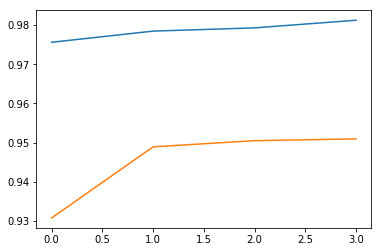

In [106]:
pyplot.plot(model_output.history['acc'])
pyplot.plot(dyn_model_output.history['acc'])

In [71]:
pyplot.show()

In [72]:
model_output.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200, 200)          16400     
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               4000100   
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
Total params: 4,016,500
Trainable params: 4,016,500
Non-trainable params: 0
_________________________________________________________________


In [76]:
dyn_model.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10_input (InputLayer)  (None, 200, 81)           0         
_________________________________________________________________
dense_10 (Dense)             (None, 200, 512)          41984     
_________________________________________________________________
dense_11 (Dense)             (None, 200, 512)          262656    
_________________________________________________________________
dense_12 (Dense)             (None, 200, 512)          262656    
_________________________________________________________________
dense_13 (Dense)             (None, 200, 100)          51300     
Total params: 618,596
Trainable params: 618,596
Non-trainable params: 0
_________________________________________________________________


In [85]:
#### Cross validation for begin marker

In [53]:
kfold = KFold(n_splits=5)

In [54]:
layers = [ { 'hidden_nb': 512, 'activation': 'relu'} , { 'hidden_nb': 512, 'activation': 'relu'}, { 'hidden_nb': 512, 'activation': 'relu'}, { 'hidden_nb': 100, 'activation': 'relu'}]

In [55]:
def accuracy_model(y_true, y_predicted):
    nb_predicted = sum([ y_true[i, np.argmax(y_predicted[i])] for i in range(len(y_predicted)) ])
    return nb_predicted / len(y_predicted)

In [56]:
def accuracy_model_dirty(y_true, y_predicted):
    nb_predicted = sum([ 1 if np.argmax(y_true[i]) <= np.argmax(y_predicted[i]) else 0 for i in range(len(y_predicted)) ])
    return nb_predicted / len(y_predicted)    

In [58]:
for train, test in kfold.split(X):
    model = build_dyn_model((pad_size, len(vocab)), layers)
    model.fit(X[train], Y_begin[train], BATCH, EPOCHS, class_weight=begin_class_weights)
    print("Model accuracy %f" % accuracy_model(Y_begin[test], model.predict(X[test])))

Epoch 1/4
10664/10664 [==============================] - 11s 1ms/step - loss: 1.2115 - acc: 0.9300
Epoch 2/4
10664/10664 [==============================] - 11s 1ms/step - loss: 0.7603 - acc: 0.9483
Epoch 3/4
10336/10664 [============================>.] - ETA: 0s - loss: 0.6810 - acc: 0.9511

KeyboardInterrupt: 

In [159]:
### Cross validation for end marker

In [59]:
for train, test in kfold.split(X):
    model = build_dyn_model((pad_size, len(vocab)), layers)
    model.fit(X[train], Y_end[train], BATCH, EPOCHS, class_weight=end_class_weights)
    print("Model accuracy %f" % accuracy_model(Y_end[test], model.predict(X[test])))
    print("Model accuracy dirty %f" % accuracy_model_dirty(Y_end[test], model.predict(X[test])))

Epoch 1/4
10664/10664 [==============================] - 11s 1ms/step - loss: 1.3496 - acc: 0.8178
Epoch 2/4
10664/10664 [==============================] - 11s 1ms/step - loss: 0.4366 - acc: 0.9435
Epoch 3/4
10664/10664 [==============================] - 11s 1ms/step - loss: 0.1914 - acc: 0.9675
Epoch 4/4
10664/10664 [==============================] - 11s 1ms/step - loss: 0.1031 - acc: 0.9826
Model accuracy 0.924634
Model accuracy dirty 0.958005
Epoch 1/4
10665/10665 [==============================] - 11s 1ms/step - loss: 1.2983 - acc: 0.8248
Epoch 2/4
10665/10665 [==============================] - 11s 1ms/step - loss: 0.4375 - acc: 0.9420
Epoch 3/4
10665/10665 [==============================] - 11s 1ms/step - loss: 0.2247 - acc: 0.9687
Epoch 4/4
10665/10665 [==============================] - 11s 1ms/step - loss: 0.1378 - acc: 0.9811: 1s - loss: 0.
Model accuracy 0.920855
Model accuracy dirty 0.967367
Epoch 1/4
10665/10665 [==============================] - 11s 1ms/step - loss: 1.3657 

In [161]:
a = model.predict(X[test[0]:test[0]+1])

In [141]:
np.argmax(a[0])

12

In [149]:
Y_end[test]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
### Extract merchant_string

In [90]:
def extract_merchant_string_with_model(model_for_start, model_for_end, text_vector):
    X = np.zeros((text_vector.shape[0], pad_size, len(vocab)))
    for i, vector in enumerate(text_vector):
        for j, char in enumerate(vector):
            X[i, j, char] = 1
    return list(zip( \
        [ np.argmax(pred) for pred in model_for_start.predict(X) ], \
        [ np.argmax(pred) for pred in model_for_end.predict(X) ] \
    ))

In [49]:
# Build model for predicting start index

In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_begin, train_size=0.8)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [47]:
model_s = build_model((pad_size, len(vocab)))
model_s.fit(x_train, y_train, BATCH, EPOCHS, class_weight=begin_class_weights)

Epoch 1/4
10664/10664 [==============================] - 5s 478us/step - loss: 1.1537 - acc: 0.9321
Epoch 2/4
10664/10664 [==============================] - 3s 323us/step - loss: 0.6864 - acc: 0.9527
Epoch 3/4
10664/10664 [==============================] - 3s 324us/step - loss: 0.4789 - acc: 0.9583
Epoch 4/4
10664/10664 [==============================] - 3s 324us/step - loss: 0.3533 - acc: 0.9652


In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_end, train_size=0.8)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [49]:
model_e = build_model((pad_size, len(vocab)))
model_e.fit(x_train, y_train, BATCH, EPOCHS, class_weight=end_class_weights)

Epoch 1/4
10664/10664 [==============================] - 4s 331us/step - loss: 1.7356 - acc: 0.7651
Epoch 2/4
10664/10664 [==============================] - 3s 318us/step - loss: 0.4942 - acc: 0.9195
Epoch 3/4
10664/10664 [==============================] - 3s 319us/step - loss: 0.2628 - acc: 0.9556
Epoch 4/4
10664/10664 [==============================] - 3s 318us/step - loss: 0.1571 - acc: 0.9690


In [91]:
def df_extract_string(row):
    indexes = extract_merchant_string_with_model(model_s, model_e, np.array([row[0]]))
    return row[1][indexes[0][0]: indexes[0][1]]

In [92]:
data['extracted_merchant_name'] = data[['encoded_text_padded', 'raw_trans_string']].apply(df_extract_string, axis=1)

NameError: ("name 'model_s' is not defined", 'occurred at index 5140')

In [89]:
data[['merchant_string', 'raw_trans_string', 'extracted_merchant_name', 'clean_trans_string']].to_csv(out_file_name, sep="|")

KeyError: "['extracted_merchant_name'] not in index"

In [93]:
#### Extracting for leave out data only

In [94]:
train_data, test_data = train_test_split(data, train_size=0.8)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [95]:
train_data_ohe_x = one_hot_encode_df(train_data, 'encoded_text_padded', pad_size, len(vocab))

In [96]:
train_data_ohe_y_start = to_categorical(train_data['begin_marker'].values, int(pad_size / 2))
train_data_ohe_y_end = to_categorical(train_data['end_marker'].values, int(pad_size / 2))

In [97]:
model_s = build_model((pad_size, len(vocab)))
model_s.fit(train_data_ohe_x, train_data_ohe_y_start, BATCH, EPOCHS, class_weight=begin_class_weights)

Epoch 1/4
10664/10664 [==============================] - 10s 967us/step - loss: 1.1584 - acc: 0.9321
Epoch 2/4
10664/10664 [==============================] - 4s 361us/step - loss: 0.6899 - acc: 0.9515
Epoch 3/4
10664/10664 [==============================] - 4s 352us/step - loss: 0.5116 - acc: 0.9586
Epoch 4/4
10664/10664 [==============================] - 4s 341us/step - loss: 0.3699 - acc: 0.9657


In [98]:
model_e = build_model((pad_size, len(vocab)))
model_e.fit(train_data_ohe_x, train_data_ohe_y_end, BATCH, EPOCHS, class_weight=end_class_weights)

Epoch 1/4
10664/10664 [==============================] - 4s 329us/step - loss: 1.6845 - acc: 0.7730
Epoch 2/4
10664/10664 [==============================] - 3s 315us/step - loss: 0.4735 - acc: 0.9231
Epoch 3/4
10664/10664 [==============================] - 3s 315us/step - loss: 0.2618 - acc: 0.9535
Epoch 4/4
10664/10664 [==============================] - 3s 313us/step - loss: 0.1603 - acc: 0.9737


In [99]:
test_data['extracted_merchant_name'] = test_data[['encoded_text_padded', 'raw_trans_string']].apply(df_extract_string, axis=1)

/home/showy/pythonenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
test_data[['merchant_string', 'raw_trans_string', 'extracted_merchant_name', 'clean_trans_string']].to_csv(out_file_name, sep="|")

In [101]:
### Extracting for the dataframe without the merchant name in the text

In [1]:
df_without_merchant_in_string['extracted_merchant_name'] = df_without_merchant_in_string[['encoded_text_padded', 'raw_trans_string']].apply(df_extract_string, axis=1)

NameError: name 'df_without_merchant_in_string' is not defined

In [102]:
out_file_name = 'data/merchants_data_extracted_without_merchant_name.csv'

In [103]:
df_without_merchant_in_string[['merchant_string', 'raw_trans_string', 'extracted_merchant_name', 'clean_trans_string']].to_csv(out_file_name, sep="|")